In [36]:
import numpy as np
from numpy import array
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
import pickle
import string
import os
import glob
from PIL import Image
from time import time
from tensorflow.keras import Input, layers
from tensorflow.keras import optimizers
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Dense, Activation, Flatten, Reshape, Dropout
from tensorflow.keras.layers import Bidirectional
from tensorflow.keras.layers import add
from tensorflow.keras.applications import MobileNetV3Large
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical

In [37]:
# try:
#     tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
#     print('Device:', tpu.master())
#     tf.config.experimental_connect_to_cluster(tpu)
#     tf.tpu.experimental.initialize_tpu_system(tpu)
#     strategy = tf.distribute.experimental.TPUStrategy(tpu)
# except:
#     strategy = tf.distribute.get_strategy()
# print('Number of replicas:', strategy.num_replicas_in_sync)

In [38]:
import tensorflow as tf
from tensorflow import keras
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.__version__)


Num GPUs Available:  2
2.11.0


In [39]:
token_path = "/kaggle/input/textfiles/Flickr30k_text/Flickr30k.token.txt"
train_images_path = '/kaggle/input/textfiles/Flickr30k_text/Flickr_30k.trainImages.txt'
test_images_path = '/kaggle/input/textfiles/Flickr30k_text/Flickr_30k.testImages.txt'
val_images_path = '/kaggle/input/textfiles/Flickr30k_text/Flickr_30k.devImages.txt'
images_path = '/kaggle/input/flickr30k/images/'
glove_path = '/kaggle/input/glove6b'
# string of all image descriptions from the dataset token file
doc = open(token_path,'r').read()
print(doc[:410])

1000092795.jpg#0	Two young guys with shaggy hair look at their hands while hanging out in the yard .
1000092795.jpg#1	Two young , White males are outside near many bushes .
1000092795.jpg#2	Two men in green shirts are standing in a yard .
1000092795.jpg#3	A man in a blue shirt standing in a garden .
1000092795.jpg#4	Two friends enjoy time spent together .
10002456.jpg#0	Several men in hard hats are operatin


In [40]:
#create a dict which maps image id to its captions or descriptions
descriptions = dict()
for line in doc.split('\n'):#loop over each line
        tokens = line.split()#split current line into individual words
        if len(line) > 2:#safety check to check if we got valid lines or not
          image_id = tokens[0].split('.')[0]# get the image id from tokens list
          image_desc = ' '.join(tokens[1:])#concatenate all remaining tokens which is image description
          if image_id not in descriptions:
              descriptions[image_id] = list() #if id is not in descriptions set it to empty value
          descriptions[image_id].append(image_desc)#append id to its captions

In [41]:
table = str.maketrans('', '', string.punctuation)#transition table which will remove punctuation
for key, desc_list in descriptions.items():#loop over image id and list of descs
    for i in range(len(desc_list)):#iterate over each caption  and split into words then lower case them all
        desc = desc_list[i]
        desc = desc.split()
        desc = [word.lower() for word in desc]
        desc = [w.translate(table) for w in desc]#remove punctuation 
        desc_list[i] =  ' '.join(desc)

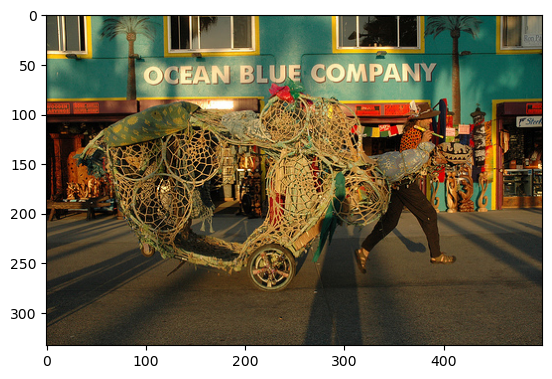

['a man is pulling a cart on wheels loaded with nets and is in front of the ocean blue company ',
 'a person walks with an artistic contraption in front of the ocean blue company ',
 'the man in the hat and sandals is pulling a cart behind him ',
 'a man pulling around some odd thing on wheels ',
 'man pulling a cart in the street ']

In [42]:
pic = '2199250692.jpg'
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()
descriptions['2199250692']

In [43]:
#loop over all descriptions split into words and create a vocab with all words and get the length
vocabulary = set()
for key in descriptions.keys():
        [vocabulary.update(d.split()) for d in descriptions[key]]
print('Original Vocabulary Size: %d' % len(vocabulary))

Original Vocabulary Size: 20009


In [44]:
#create a list and append each caption to its image id like imageid1:caption1 id1:caption2
lines = list()
for key, desc_list in descriptions.items():
    for desc in desc_list:
        lines.append(key + ' ' + desc)
new_descriptions = '\n'.join(lines)

In [45]:
#read names of image files in from the txt file and append the image identifier to the list
doc = open(train_images_path,'r').read()
dataset = list()
for line in doc.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)
#add all the identifiers to the train var
train = set(dataset)

In [46]:
#read names of image files in from the txt file and append the image identifier to the list
doc2 = open(val_images_path,'r').read()
dataset = list()
for line in doc2.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)
#add all the identifiers to the train var
val = set(dataset)

In [47]:
#read names of image files in from the txt file and append the image identifier to the list
doc3 = open(test_images_path,'r').read()
dataset = list()
for line in doc3.split('\n'):
    if len(line) > 1:
      identifier = line.split('.')[0]
      dataset.append(identifier)
#add all the identifiers to the train var
test = set(dataset)

In [48]:
#seperate images into train , val and test based from the txt files 
img = glob.glob(images_path + '*.jpg')#get list of all image files that end with jpg
train_images = set(open(train_images_path, 'r').read().strip().split('\n'))
train_img = []
for i in img: 
    if i[len(images_path):] in train_images:
        train_img.append(i)

test_images = set(open(test_images_path, 'r').read().strip().split('\n'))
test_img = []
for i in img: 
    if i[len(images_path):] in test_images: 
        test_img.append(i)

val_images = set(open(val_images_path, 'r').read().strip().split('\n'))
val_img = []
for i in img: 
    if i[len(images_path):] in val_images:
        val_img.append(i)

In [49]:
#create a dict with just the captions of the train images and their image id
train_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in train:
        if image_id not in train_descriptions:#if id is not in present add empty value
            train_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'#padd it with start and end tokens
        train_descriptions[image_id].append(desc)

In [50]:
#create a dict with just the captions of the train images and their image id
val_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in val:
        if image_id not in val_descriptions:#if id is not in present add empty value
            val_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'#padd it with start and end tokens
        val_descriptions[image_id].append(desc)

In [51]:
#create a dict with just the captions of the train images and their image id
test_descriptions = dict()
for line in new_descriptions.split('\n'):
    tokens = line.split()
    image_id, image_desc = tokens[0], tokens[1:]
    if image_id in test:
        if image_id not in test_descriptions:#if id is not in present add empty value
            test_descriptions[image_id] = list()
        desc = 'startseq ' + ' '.join(image_desc) + ' endseq'#padd it with start and end tokens
        test_descriptions[image_id].append(desc)

In [52]:
#create a list of all training captions to fit the caption generating model
all_train_captions = []
for key, val in train_descriptions.items():
    for cap in val:
        all_train_captions.append(cap)


In [53]:
all_val_captions = []
for key, val in val_descriptions.items():
    for cap in val:
        all_val_captions.append(cap)

In [54]:
all_test_captions = []
for key, val in test_descriptions.items():
    for cap in val:
        all_test_captions.append(cap)

In [55]:
#count occurence of words in captions and filter out ones under the threshold
word_count_threshold = 10
word_counts = {}
nsents = 0
for sent in all_train_captions:#loop over each sentence
    nsents += 1
    for w in sent.split(' '):#loop over each word in sentence
        word_counts[w] = word_counts.get(w, 0) + 1#update word count for the current word
vocab = [w for w in word_counts if word_counts[w] >= word_count_threshold]#take words that meet the threshold

print('Vocabulary = %d' % (len(vocab)))

Vocabulary = 5091


In [56]:
#initialize two dicts word to index and index to word
ixtoword = {}
wordtoix = {}
ix = 1
for w in vocab:#loop over words and create their indexes and increment index each time
    wordtoix[w] = ix
    ixtoword[ix] = w
    ix += 1

vocab_size = len(ixtoword) + 1 # +1 because index zero is for the padding sequences
print(vocab_size)

5092


In [57]:
#cpmpute the max length of captions in the training dataset
all_desc = list()
for key in train_descriptions.keys():#get the captions for each key available
    [all_desc.append(d) for d in train_descriptions[key]]
lines = all_desc
max_length = max(len(d.split()) for d in lines)#split into words and count them then get max length

print('Description Length: %d' % max_length)

Description Length: 74


In [60]:
#load pretrained word embeddings from global vectors with 200 dimensions
embeddings_index = {} 
f = open(os.path.join(glove_path, '/kaggle/input/glove6b/glove.6B.300d.txt'), encoding="utf-8")
for line in f:
    values = line.split()#split line into list of values
    word = values[0]#extract the word from the first element in values
    coefs = np.asarray(values[1:], dtype='float32')#convert the rest to vector of numbers representing the embedding
    
    embeddings_index[word] = coefs#add word and embedding vector to an embedding index
    # so we have the key and embedding vector as value

In [61]:
#create embedding matrix using pre-trained word embedding to initalie the neural networks embedding layer
embedding_dim = 300
embedding_matrix = np.zeros((vocab_size, embedding_dim))
#each row in matrix will corrspond to a word and each column to embedding dims
for word, i in wordtoix.items():#iterate through each word and index
    embedding_vector = embeddings_index.get(word)#get pre trained vectors for the current word
    if embedding_vector is not None:#if the current word has pretrained embedding
        embedding_matrix[i] = embedding_vector#the corrosponding row will be updated to that embedding
        #otherwise the row will remain zero
embedding_matrix.shape

(5092, 300)

In [62]:
#create the model using the weights downloaded from imagenet
model = MobileNetV3Large(weights='imagenet', include_top=True)
model.summary()
model_new = Model(model.input, model.layers[-9].output)
model_new.summary()

# created the new model with the output layer removed because it will be used 
# as a feature extractor for transfer learning

Model: "MobilenetV3large"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 rescaling_1 (Rescaling)        (None, None, None,   0           ['input_4[0][0]']                
                                3)                                                                
                                                                                                  
 Conv (Conv2D)                  (None, None, None,   432         ['rescaling_1[0][0]']            
                                16)                                                

In [63]:
#function to take the image and resize it to 224 for MobileNetV3
# then convert to array becuz keras only accepts numpy arrays
def preprocess(image_path):
    img = image.load_img(image_path, target_size=(224, 224))
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)# add extra dim at axis=0 because 
    #keras expects a batch of images as input axis=0 is batch size of 1
    x = preprocess_input(x) #apply preprocessing like scaling pixel values and such
    return x# return array (1,224,224,3) shaped

In [64]:
#encoding func takes the image and return the features as a feature vector 
# Define the encode function to obtain the image features using the MobileNet model
def encode(image):
    image = preprocess(image) 
    fea_vec = model_new.predict(image) 
    fea_vec = np.reshape(fea_vec, (fea_vec.shape[1]*fea_vec.shape[2]*fea_vec.shape[3],))
    return fea_vec


In [65]:
# # Compute the image features for each image in the training and test sets
# encoding_train = {}
# for img in train_img:
#     encoding_train[img[len(images_path):]] = encode(img)
# train_features = encoding_train

# with open('train_features.pkl', 'wb') as f:
#     pickle.dump(encoding_train, f)

# encoding_test = {}
# for img in test_img:
#     encoding_test[img[len(images_path):]] = encode(img)
# test_features = encoding_test

# with open('test_features.pkl', 'wb') as f:
#     pickle.dump(encoding_test, f)

# encoding_val = {}
# for img in val_img:
#     encoding_val[img[len(images_path):]] = encode(img)
# val_features = encoding_val

# with open('val_features.pkl', 'wb') as f:
#     pickle.dump(encoding_val, f)



In [66]:


# Load the saved encoding dictionaries from disk using pickle
with open('/kaggle/input/readyfeatures/train_features.pkl', 'rb') as f:
    train_features = pickle.load(f)

with open('/kaggle/input/readyfeatures/test_features.pkl', 'rb') as f:
    test_features = pickle.load(f)

with open('/kaggle/input/readyfeatures/val_features.pkl', 'rb') as f:
    val_features = pickle.load(f)


In [67]:
# import tensorflow as tf
# from tensorflow.keras.layers import Input, Dense, Dropout, Embedding, LSTM, add

# Define the input layers for the LSTM-based model
inputs1 = Input(shape=(1280,))
fe1 = Dropout(0.5)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)

inputs2 = Input(shape=(max_length,))
se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
se2 = Dropout(0.5)(se1)
se3 = LSTM(256)(se2)

# Combine the image features and caption input using the add layer
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

# Define the model with the input and output layers
model = tf.keras.Model(inputs=[inputs1, inputs2], outputs=outputs)
model.summary()


Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 74)]         0           []                               
                                                                                                  
 input_5 (InputLayer)           [(None, 1280)]       0           []                               
                                                                                                  
 embedding_1 (Embedding)        (None, 74, 300)      1527600     ['input_6[0][0]']                
                                                                                                  
 dropout_4 (Dropout)            (None, 1280)         0           ['input_5[0][0]']                
                                                                                            

In [68]:
model.layers[2].set_weights([embedding_matrix])#set weights of the 3rd layer to the pre trained embeddings
model.layers[2].trainable = False#dont update the weights so freeze it 
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])#multi class classification


In [69]:

def data_generator(descriptions, photos, wordtoix, max_length, num_photos_per_batch):
    X1, X2, y = list(), list(), list() #store image input, input sequence, output
    n=0
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
            n+=1
            # retrieve the photo feature
            photo = photos[key+'.jpg']
            for desc in desc_list:
                # encode the sequence
                seq = [wordtoix[word] for word in desc.split(' ') if word in wordtoix]
                # split one sequence into multiple X, y pairs
                for i in range(1, len(seq)):
                    # split into input and output pair
                    in_seq, out_seq = seq[:i], seq[i]
                    # pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    # store
                    X1.append(photo)
                    X2.append(in_seq)
                    y.append(out_seq)

            if n==num_photos_per_batch:
                yield ([array(X1), array(X2)], array(y))
                X1, X2, y = list(), list(), list()
                n=0#reset to zero to get ready for next batch

In [70]:
epochs = 15
batch_size = 10
steps = len(train_descriptions)//batch_size
steps2 = len(val_descriptions)//batch_size

# Add checkpoint to save the best model
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True)

# Add early stopping to stop training early if the model doesn't improve
early_stop = EarlyStopping(monitor='val_loss', patience=4)

# Add tensorboard to visualize training progress
tensorboard = TensorBoard(log_dir='./logs', histogram_freq=0, write_graph=True, write_images=False)

generator = data_generator(train_descriptions, train_features, wordtoix, max_length, batch_size)
generator2 = data_generator(val_descriptions, val_features, wordtoix, max_length, batch_size)

model.fit(generator, epochs=epochs, steps_per_epoch=steps,validation_data=generator2,validation_steps=steps2,callbacks=[checkpoint,early_stop, tensorboard], verbose=1)

Epoch 1/15
2778/2778 [==============================] - 795s 284ms/step - loss: 3.7431 - accuracy: 0.3135 - val_loss: 3.2564 - val_accuracy: 0.3596
Epoch 2/15
2778/2778 [==============================] - 788s 284ms/step - loss: 3.1847 - accuracy: 0.3587 - val_loss: 3.1167 - val_accuracy: 0.3751
Epoch 3/15
2778/2778 [==============================] - 770s 277ms/step - loss: 3.0392 - accuracy: 0.3710 - val_loss: 3.0777 - val_accuracy: 0.3804
Epoch 4/15
2778/2778 [==============================] - 774s 279ms/step - loss: 2.9580 - accuracy: 0.3776 - val_loss: 3.0653 - val_accuracy: 0.3847
Epoch 5/15
2778/2778 [==============================] - 764s 275ms/step - loss: 2.9041 - accuracy: 0.3825 - val_loss: 3.0691 - val_accuracy: 0.3865
Epoch 6/15
2778/2778 [==============================] - 773s 278ms/step - loss: 2.8645 - accuracy: 0.3854 - val_loss: 3.0713 - val_accuracy: 0.3883
Epoch 7/15
2778/2778 [==============================] - 766s 276ms/step - loss: 2.8342 - accuracy: 0.3881 - val_

In [106]:
test_generator = data_generator(test_descriptions, test_features, wordtoix, max_length, batch_size)
steps3 = len(test_descriptions) 


# Evaluate the model on the test dataset
#test_loss = model.evaluate(test_generator, steps=steps3)

score = model.evaluate(test_generator,steps = steps3, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])


2000/2000 [==============================] - 111s 55ms/step - loss: 3.0435 - accuracy: 0.3949
Test loss: 3.0435070991516113
Test accuracy: 0.39491885900497437


In [73]:
#selects the words with the highest probability to be next
def greedySearch(photo):
    in_text = 'startseq'
    for i in range(max_length):
        sequence = [wordtoix[w] for w in in_text.split() if w in wordtoix]
        sequence = pad_sequences([sequence], maxlen=max_length)
        yhat = model.predict([photo,sequence], verbose=0)
        yhat = np.argmax(yhat)
        word = ixtoword[yhat]
        in_text += ' ' + word
        if word == 'endseq':
            break

    final = in_text.split()
    final = final[1:-1]
    final = ' '.join(final)
    return final

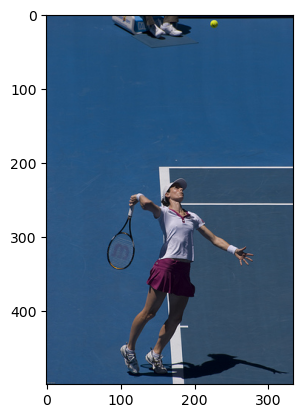

Caption: a tennis player is playing tennis


In [108]:
pic = list(test_features.keys())[5]
image = test_features[pic].reshape((1,1280))
x=plt.imread(images_path+pic)
plt.imshow(x)
plt.show()

print("Caption:",greedySearch(image))



In [115]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard
%load_ext tensorboard
%tensorboard --logdir /kaggle/input/logfiles/logs/train



The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 30144), started 0:02:57 ago. (Use '!kill 30144' to kill it.)